# Introduction

In this section, we will present an analysis of A/B tests and the RICE and ICE scoring methods to facilitate decision-making for a large online store.

1. We will deliver the results of the ICE and RICE indicators, highlighting the relevance of the hypotheses and identifying which ones should be prioritized in the decision-making process.
2. We will provide results from the A/B tests in order to validate the data and identify any anomalies or differences that could challenge the proposed hypotheses.
3. We will offer observations on the results to help facilitate understanding and assist with the analysis.

In [1]:
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
hipotesis = pd.read_csv('/datasets/hypotheses_us.csv', sep = ';' )
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

In [3]:
print(hipotesis.info())
print(orders.info())
print(visits.info())

# The information extracted from info() tells us that we do not have null information.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data col

In [4]:
# I made the information adjustments that may be necessary for our analysis

hipotesis = hipotesis.rename(str.lower, axis = 'columns')
orders = orders.rename(str.lower, axis = 'columns')
orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d')
visits['date'] = pd.to_datetime(visits['date'], format = '%Y-%m-%d')


In [5]:
# Validation of possible duplicate assignment

pivot_ = orders.pivot_table(index = 'visitorid', columns = 'group', values = 'transactionid', aggfunc = 'count')
pivot_ = pivot_.reset_index()
pivot_ = pivot_.fillna(0)
filtro = pivot_[(pivot_['A'] == 0)&(pivot_['B'] == 0)]
print(filtro)
# I did not find any visitors with double group assignment

Empty DataFrame
Columns: [visitorid, A, B]
Index: []


In [6]:
# I performed a duplicate drop in case of having duplicate data

visits = visits.drop_duplicates()
orders = orders.drop_duplicates()

print(visits.info())
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 56.1+ KB
None


In [7]:
# 1. ICE and RICE tests

hipotesis['ICE'] =  (hipotesis['impact'] * hipotesis['confidence'])/ hipotesis['effort']
ICE_report = (hipotesis[['hypothesis','ICE']]).sort_values(by = 'ICE', ascending = False)

hipotesis['RICE'] =  (hipotesis['reach']*hipotesis['impact'] * hipotesis['confidence'])/ hipotesis['effort']
RICE_report = (hipotesis[['hypothesis','RICE']]).sort_values(by = 'RICE', ascending = False)
print(ICE_report)
print(RICE_report)

                                          hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000
                                          hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2


# ICE and RICE Categorization

Both categories can be relevant for decision-making. We observe that the "Reach" aspect generates several changes in the categorization. Depending on the company's objectives and their scale of importance, they should choose between the categories provided by ICE or RICE.

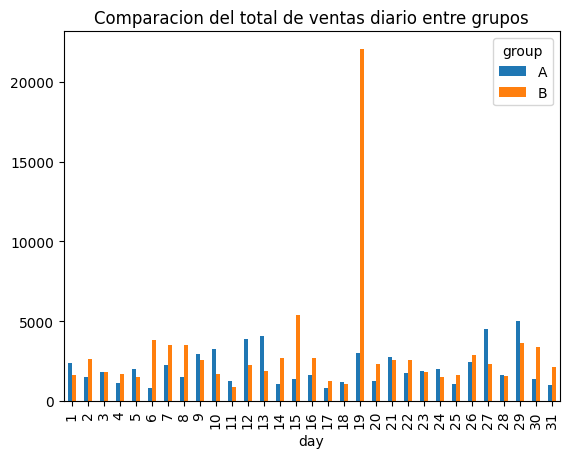

In [8]:
# Graphical representation of income by group

orders['week'] = orders['date'].dt.week
orders['day'] = orders['date'].dt.day

total_revenue = revenue_avg = orders.pivot_table(index = 'day', columns = 'group', values = 'revenue', aggfunc = 'sum')

total_revenue.plot(kind='bar', title = 'Comparison of total daily sales between groups')
plt.show()

# Start of A/B Tests
# 1. Sales Comparison Between Groups

In the A/B tests, we aim to divide our sample into two groups and evaluate their behavioral patterns. If the differences are significant, we will need to continue testing and question the accuracy of our hypotheses.
At first glance, we notice that total monthly sales differ quite a bit between the groups. Group B shows higher sales volume than Group A, which suggests that we may have significant differences.

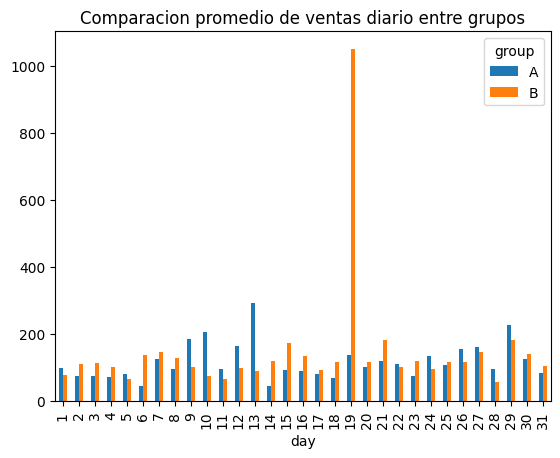

In [9]:
# Graphical representation by average order
revenue_avg = orders.pivot_table(index = 'day', columns = 'group', values = 'revenue', aggfunc = 'mean')

revenue_avg.plot(kind='bar', title = 'Comparison of average daily sales between groups')
plt.show()

# 2. Comparison of Average Revenue Per User

Here, we observe the same behavior as with total sales—Group B stands out over Group A in terms of average revenue. However, we may have some outliers in Group B that could skew the average.

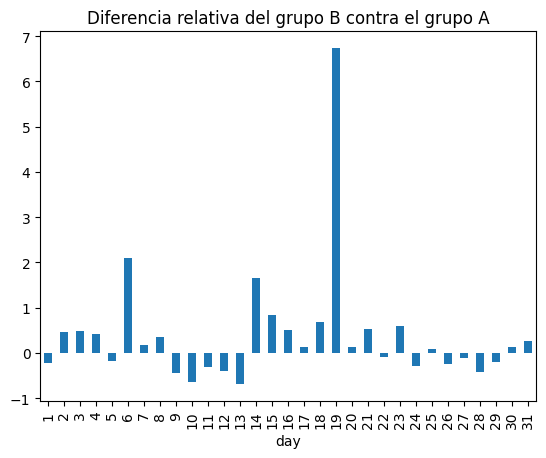

In [10]:
# Calculation of the relative difference between group B and group A

relative_diference = orders.pivot_table(index = 'date', columns = 'group', values = 'revenue', aggfunc = 'mean')
relative_diference = relative_diference.reset_index()
relative_diference['diferencia'] =  (relative_diference['B'] - relative_diference['A'])/relative_diference['A']
relative_diference['day'] = relative_diference['date'].dt.day
relative_diference.plot(x= 'day', y= 'diferencia', kind = 'bar', title = 'Relative difference between group B and group A', legend = False)

plt.show()

# 3. Relative Difference Between Group B and Group A

From the previous analysis, we saw that Group B outperforms Group A. This warrants a relative difference analysis, which shows a positive difference for most of the month and a significant difference on certain days.

In [11]:
# Calculate conversion rate

orders_by_group = orders.groupby(['date','group'])['transactionid'].count()
orders_by_group.name = 'orders'
visits = visits.join(orders_by_group, on =['date','group'])

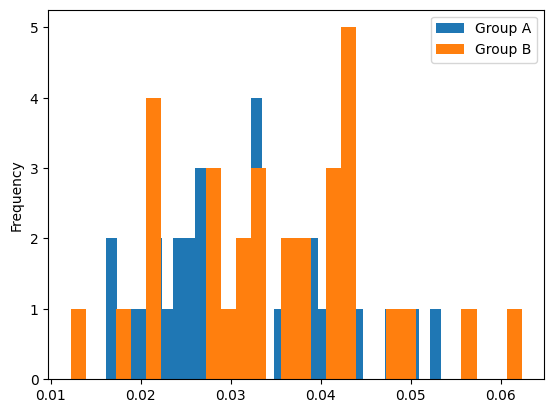

In [12]:
visits['convertion'] = visits['orders']/visits['visits']
visits['week'] = visits['date'].dt.week

visits[visits['group'] == 'A']['convertion'].plot(kind = 'hist', bins = 30)
visits[visits['group'] == 'B']['convertion'].plot(kind = 'hist', bins = 30)

plt.legend(['Group A','Group B'])
plt.show()

 # 4. Conversion Rate Calculation
 
To further explore the differences between both groups, we compare their conversion rates, aiming to identify any user behavior discrepancies. Just like in the revenue analysis, we observe that Group B exhibits better conversion rates on certain days. However, both groups show several data points around the median of the graph. This suggests that outliers might be benefiting Group B. Now, we need to determine whether this is due to the number of users or the transaction amounts.

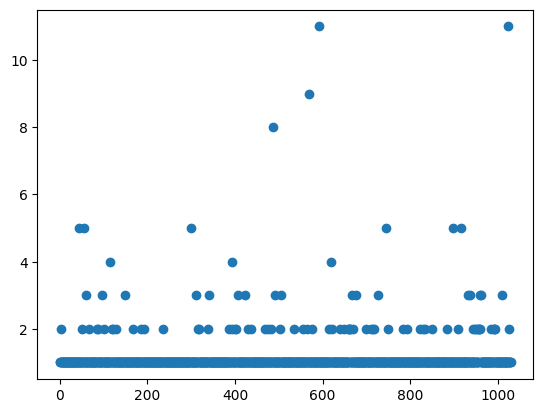

1197


In [13]:
# Scatter plot for the number of orders per user

orders_by_user = orders.groupby('visitorid')['transactionid'].count()

x_values = pd.Series(range(0, 1031))

plt.scatter(x_values, orders_by_user )
plt.show()

print(orders_by_user.sum())

# 5. User Dispersion Analysis

At first glance, we notice that most users make only one purchase. Outliers may start from users who have made more than one purchase, but this information seems incomplete without knowing the amounts of each transaction. The data won’t be relevant if the transaction amounts are close to the average.

In [14]:
# Calculating percentiles for the number of orders per user

percentiles = np.percentile(orders_by_user, [90,95,99])

print(percentiles)

[1. 2. 4.]


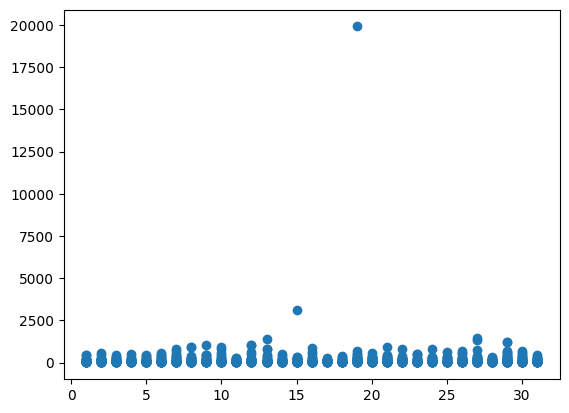

In [15]:
# Scatter plot for average order value per user

plt.scatter(orders['day'],orders['revenue'])
plt.show()

# 6. Dispersion Analysis by Average Order Value

This chart complements the previous analysis. In the earlier graph, we saw many outliers across the entire sample, while here the outliers seem to be minimal. We observe that the value of each transaction becomes more significant, and these few outliers represent amounts far above the average. Next, we will check the statistical significance and compare the raw data, removing the outliers, to evaluate if we truly have significant differences.

In [16]:
# Calculation of percentiles for the average value of each order

percentiles = np.percentile(orders['revenue'], [90,95,99])

print(percentiles)

[282.48  435.54  900.904]


In [17]:
# Calculation of the statistical raw significance for the daily conversion of each group

conversion_A = visits.query("group == 'A'")['convertion'].sort_values()
conversion_B = visits.query("group == 'B'")['convertion'].sort_values()

alpha = 0.05
test_1 = st.mannwhitneyu(conversion_A, conversion_B )

print('p-value: ', test_1.pvalue)

if (test_1.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value:  0.08587216033007773
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [18]:
# Calculation of raw statistical significance for average daily size

avg_income_A = (orders[orders['group']=='A'].groupby('day')['revenue'].mean()).sort_values()
avg_income_B = (orders[orders['group']=='B'].groupby('day')['revenue'].mean()).sort_values()

alpha = 0.05

test_2 = st.mannwhitneyu(avg_income_A, avg_income_B)

print('p-value: ', test_2.pvalue)

if (test_2.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value:  0.4222761086468382
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [19]:
# Preparing for purchase conversion calculation information, removing outlier data


orders_by_user_filtered = (orders_by_user.to_frame()).reset_index()
orders_by_user_filtered = orders_by_user_filtered.query("transactionid > 1")['visitorid']
orders_filtered = orders[orders['visitorid'].isin(orders_by_user_filtered)] # A filter is made for users who made more than one purchase

visitors_reject = orders_filtered.groupby(['day','group'])['transactionid'].count() #I made the list of visits that will be subtracted from data frame visits
visitors_reject.name = 'visitors_reject'
visits['day'] = visits['date'].dt.day

In [20]:
visits = visits.join(visitors_reject, on = ['day', 'group'])

In [21]:
# I made a conversion_ column that represents the conversion value removing the outliers

visits['visitors_reject'] = visits['visitors_reject'].fillna(0)
visits['visits_'] = visits['visits'] - visits['visitors_reject']
visits['orders_'] = visits['orders'] - visits['visitors_reject']

visits['convertion_'] = visits['orders_']/visits['visits_']


In [22]:
# Calculating daily conversion significance by removing outliers

conversion_A_alt = visits.query("group == 'A'")['convertion_'].sort_values()
conversion_B_alt = visits.query("group == 'B'")['convertion_'].sort_values()

alpha = 0.05
test_3 = st.mannwhitneyu(conversion_A_alt, conversion_B_alt)

print('p-value: ', test_3.pvalue)

if (test_3.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value:  0.05035377454756353
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


In [23]:
# Calculating statistical significance by removing outliers for average daily size

orders_alt = orders[orders['revenue'] < 282.48]

avg_income_A_alt = (orders_alt[orders_alt['group']=='A'].groupby('day')['revenue'].mean()).sort_values()
avg_income_B_alt = (orders_alt[orders_alt['group']=='B'].groupby('day')['revenue'].mean()).sort_values()

alpha = 0.05

test_4 = st.mannwhitneyu(avg_income_A_alt, avg_income_B_alt)

print('p-value: ', test_4.pvalue)

if (test_4.pvalue < alpha):
    print("Null hypothesis rejected: there are significant differences between the distributions of the two groups compared")
else:
    print("The null hypothesis could not be rejected: we cannot draw conclusions about the difference")

p-value:  0.4304627009065408
No se pudo rechazar la hipótesis nula: no podemos sacar conclusiones sobre la diferencia


# 7. Final Conclusion

By breaking down the results of each significance test, we compare the results of the raw significance against the results without the outliers. For all tests, the calculation was favorable—both conversion percentage and purchase amounts are very similar between the two groups. Even when removing the outliers, the results remain the same. The final result was contrary to our initial analysis, as the differences between the two groups seemed very significant at first. Based on this, we can conclude the test and mark Group B as the leader over Group A. Both groups are comparable, but Group B shows better results.